In [3]:
!pip install yfinance


In [4]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件

In [8]:
# 輸入股票代號
stock_id = "2464.TW"
# 時間區間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()

# 刪除 Ticker 欄位並取代
df.columns = df.columns.droplevel('Ticker')

##df.info()
df


/tmp/ipython-input-3150998257.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_id, start=start, end=end).reset_index()
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2025-03-27,70.075302,70.870486,69.975906,70.572290,1138336
1,2025-03-28,67.590363,70.075302,66.795179,69.677710,3560999
2,2025-03-31,61.924698,65.403617,61.328314,64.210842,4787351
3,2025-04-01,64.210838,64.509034,62.521082,63.515058,2235616
4,2025-04-02,64.608429,64.906625,63.415657,64.310233,1127324
...,...,...,...,...,...,...
118,2025-09-16,76.300003,77.800003,76.000000,76.599998,8327446
119,2025-09-17,74.099998,76.699997,74.000000,76.599998,4832620
120,2025-09-18,71.300003,74.699997,71.099998,74.300003,5655550
121,2025-09-19,71.000000,72.099998,70.400002,71.500000,2998845


In [10]:
# 計算8日 SMA
df['8_SMA'] = df['Close'].rolling(window=8).mean()

# 計算13日 SMA
df['13_SMA'] = df['Close'].rolling(window=13).mean()

# 計算20日 SMA
df['20_SMA'] = df['Close'].rolling(window=20).mean()

# 列印最後筆數
df.tail()

Price,Date,Close,High,Low,Open,Volume,8_SMA,13_SMA,20_SMA
118,2025-09-16,76.300003,77.800003,76.000000,76.599998,8327446,75.300000,74.553847,72.285
119,2025-09-17,74.099998,76.699997,74.000000,76.599998,4832620,75.312500,74.746154,72.695
120,2025-09-18,71.300003,74.699997,71.099998,74.300003,5655550,74.975000,74.776924,72.945
121,2025-09-19,71.000000,72.099998,70.400002,71.500000,2998845,74.462501,74.530770,73.160
122,2025-09-22,71.599998,72.599998,71.400002,71.800003,1892397,73.812500,74.169231,73.315


In [11]:
# 計算每個交易日的價格變動，即當天收盤價與前一天收盤價的差異
df['Change'] = df['Close'] - df['Close'].shift(1)

# 將變動值中的正數部分視為“Gain”（增益），如果變動為負則記為0
df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)

# 將變動值中的負數部分視為“Loss”（損失），取其絕對值，如果變動為正則記為0
df['Loss'] = df['Change'].apply(lambda x: abs(x) if x < 0 else 0)

df.tail()

# 計算過去14個交易日的平均增益
df['Avg Gain'] = df['Gain'].rolling(window=14).mean()

# 計算過去14個交易日的平均損失
df['Avg Loss'] = df['Loss'].rolling(window=14).mean()

# 計算相對強弱指數的相對強度（RS），即平均增益與平均損失的比值
df['RS'] = df['Avg Gain'] / df['Avg Loss']

# 計算相對強弱指數（RSI），使用RS公式計算出來
df['RSI'] = 100 - (100 / (1 + df['RS']))

# 顯示最後幾行的數據
df.tail()

Price,Date,Close,High,Low,Open,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI
118,2025-09-16,76.300003,77.800003,76.000000,76.599998,8327446,75.300000,74.553847,72.285,0.800003,0.800003,0.000000,0.850001,0.342857,2.479167,71.257488
119,2025-09-17,74.099998,76.699997,74.000000,76.599998,4832620,75.312500,74.746154,72.695,-2.200005,0.000000,2.200005,0.792858,0.500001,1.585713,61.325954
120,2025-09-18,71.300003,74.699997,71.099998,74.300003,5655550,74.975000,74.776924,72.945,-2.799995,0.000000,2.799995,0.678572,0.700000,0.969388,49.222810
121,2025-09-19,71.000000,72.099998,70.400002,71.500000,2998845,74.462501,74.530770,73.160,-0.300003,0.000000,0.300003,0.678572,0.671429,1.010638,50.264546
122,2025-09-22,71.599998,72.599998,71.400002,71.800003,1892397,73.812500,74.169231,73.315,0.599998,0.599998,0.000000,0.485715,0.671429,0.723405,41.975323


In [12]:
# 計算8天的指數移動平均線（EMA），並將其存儲在 'EMA_8' 列中
# adjust=False 表示在計算 EMA 時，只考慮當前值和前一個 EMA 的遞歸計算方式，而不考慮所有歷史數據
df['EMA_8'] = df['Close'].ewm(span=8, adjust=False).mean()

# 計算13天的指數移動平均線（EMA），並將其存儲在 'EMA_13' 列中
df['EMA_13'] = df['Close'].ewm(span=13, adjust=False).mean()

# 計算MACD線：8天EMA減去13天EMA，並將其存儲在 'MACD' 列中
df['MACD'] = df['EMA_8'] - df['EMA_13']

# 顯示DataFrame的最後幾行數據
df.head(3)

Price,Date,Close,High,Low,Open,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD
0,2025-03-27,70.075302,70.870486,69.975906,70.572290,1138336,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,70.075302,70.075302,0.000000
1,2025-03-28,67.590363,70.075302,66.795179,69.677710,3560999,NaN,NaN,NaN,-2.484940,0.0,2.484940,NaN,NaN,NaN,NaN,69.523093,69.720311,-0.197217
2,2025-03-31,61.924698,65.403617,61.328314,64.210842,4787351,NaN,NaN,NaN,-5.665665,0.0,5.665665,NaN,NaN,NaN,NaN,67.834561,68.606652,-0.772091


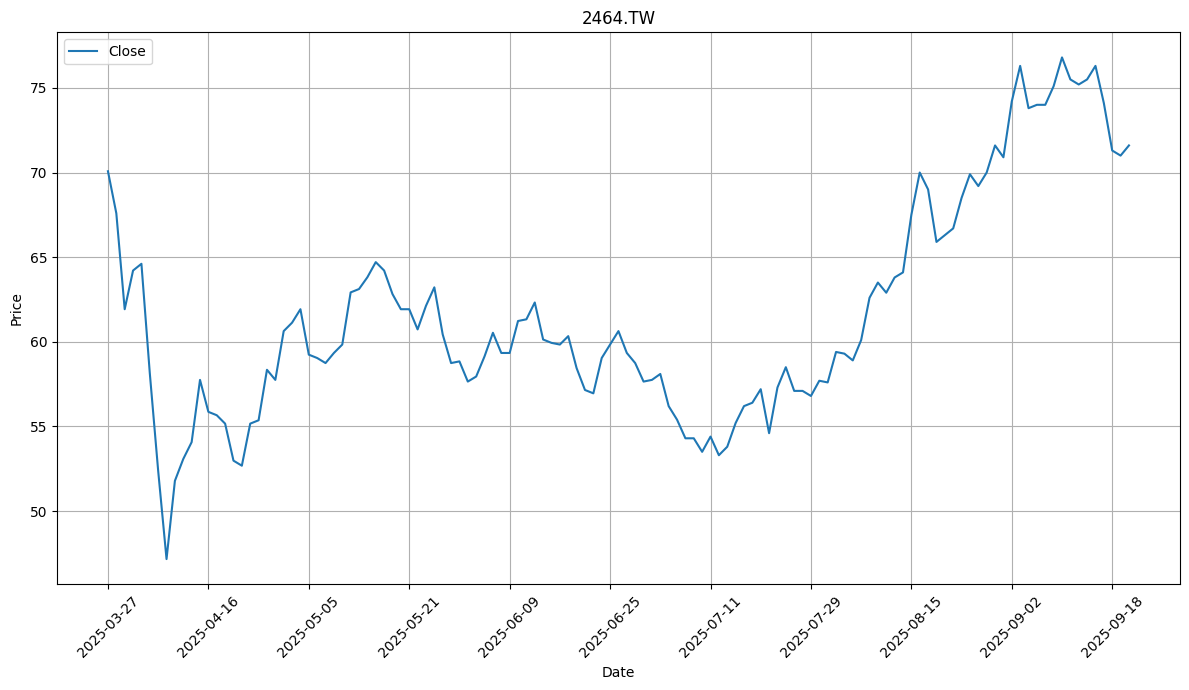

In [13]:
import matplotlib.pyplot as plt

# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['Close'], label='Close')

# 設定 x 軸的時間
num = 10
date = df["Date"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,  # 設定在 x 軸上顯示標籤的位置（索引），這些位置間隔為 len(date)//num
           date[::len(date)//num],  # 設定顯示在 x 軸上的日期標籤，數量為 num，間隔為 len(date)//num
           rotation = 45) # 讓日期標籤旋轉 45 度，以避免標籤之間重疊，提高可讀性

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()  # 自動調整圖表中的間距，避免元素之間的重疊

# 顯示圖表
plt.show()

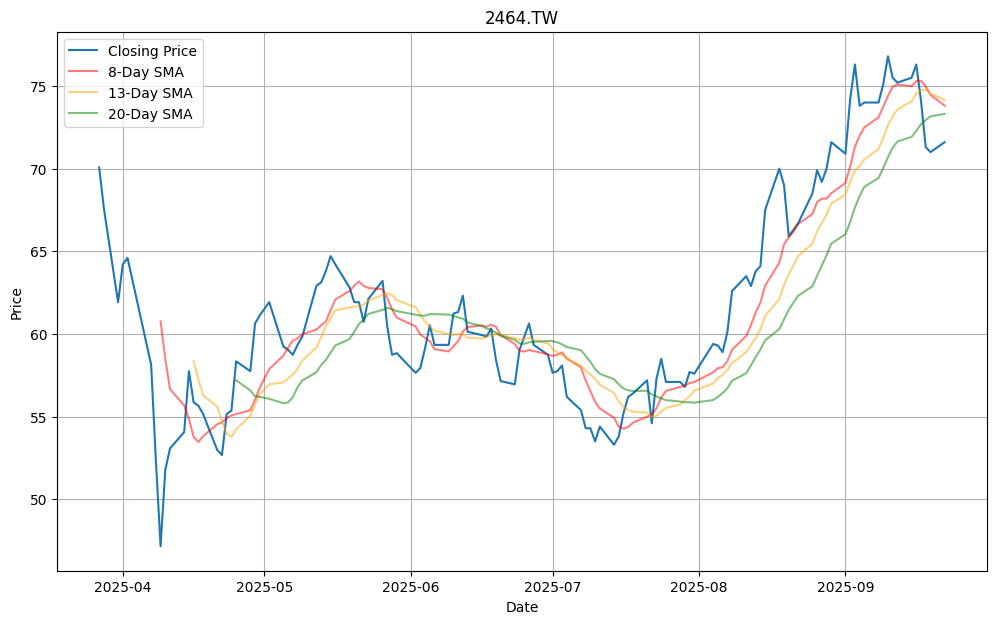

In [14]:
# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['Date'], df['Close'], label='Closing Price')

# 8 天的 SMA
plt.plot(df['Date'], df['8_SMA'], label='8-Day SMA', color='red', alpha=.5)

# 13 天的 SMA
plt.plot(df['Date'], df['13_SMA'], label='13-Day SMA', color='orange', alpha=.5)

# 20 天的 SMA
plt.plot(df['Date'], df['20_SMA'], label='20-Day SMA', color='green', alpha=.5)

# 將股票代號設為圖標
plt.title(f'{stock_id}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

In [15]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.4 MB/s eta 0:00:00


In [18]:
# 將原始的 dataframe 再建立一個出來
kplot_df = df.set_index('Date')
kplot_df['2025-08-01':'2025-09-22'].tail()

Price,Close,High,Low,Open,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD
Date,,,,,,,,,,,,,,,,,,
2025-09-16,76.300003,77.800003,76.000000,76.599998,8327446,75.300000,74.553847,72.285,0.800003,0.800003,0.000000,0.850001,0.342857,2.479167,71.257488,75.148141,74.056671,1.091470
2025-09-17,74.099998,76.699997,74.000000,76.599998,4832620,75.312500,74.746154,72.695,-2.200005,0.000000,2.200005,0.792858,0.500001,1.585713,61.325954,74.915220,74.062861,0.852359
2025-09-18,71.300003,74.699997,71.099998,74.300003,5655550,74.975000,74.776924,72.945,-2.799995,0.000000,2.799995,0.678572,0.700000,0.969388,49.222810,74.111839,73.668167,0.443672
2025-09-19,71.000000,72.099998,70.400002,71.500000,2998845,74.462501,74.530770,73.160,-0.300003,0.000000,0.300003,0.678572,0.671429,1.010638,50.264546,73.420319,73.287000,0.133319
2025-09-22,71.599998,72.599998,71.400002,71.800003,1892397,73.812500,74.169231,73.315,0.599998,0.599998,0.000000,0.485715,0.671429,0.723405,41.975323,73.015803,73.046000,-0.030197


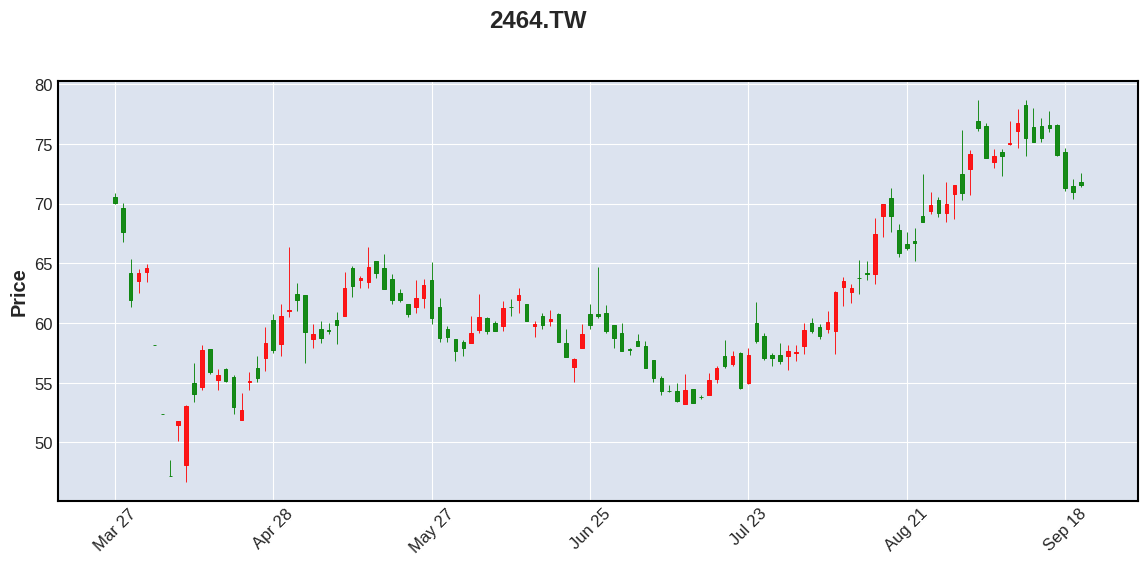

In [19]:
import mplfinance as mpf
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default',
                marketcolors=my_color)

# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', style=my_style, title=f'{stock_id}', figsize=(15, 6))

In [20]:
# 計算 K 線長度 = abs(收盤-開盤)
df['body_length'] = abs(df['Close'] - df['Open'])

# 計算下影線長度 = abs(最高-最小)
df['lower_shadow'] = abs(df['Low'] - df[['Open', 'Close']].min(axis=1))

# 計算上影線長度 = abs(最高-最小)
df['upper_shadow'] = abs(df['High'] - df[['Open', 'Close']].max(axis=1))

#print('df',df)
# 定義 Hammer 型態的條件
hammer_condition = (
    (df['lower_shadow'] > 2 * df['body_length']) &  # 下影線長於實體的两倍
    (df['upper_shadow'] < df['body_length'] * 0.1) &  # 上影線很短
    (df['body_length'] < (df['High'] - df['Low']) * 0.4)  # 實體相對較小
)

# 提取 Hammer 型態
hammer_df = df[hammer_condition]
hammer_df.set_index('Date', inplace=True)

hammer_df

Price,Close,High,Low,Open,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,...,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD,body_length,lower_shadow,upper_shadow
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-10,51.786140,51.786140,50.096385,51.487948,2635917,58.476843,NaN,NaN,4.621983,4.621983,...,NaN,NaN,NaN,NaN,57.113953,60.335517,-3.221563,0.298192,1.391564,0.0
2025-08-29,71.599998,71.599998,68.699997,70.800003,6392096,68.512500,67.884615,65.46,1.599998,1.599998,...,0.964286,0.385714,2.499999,71.428566,68.997962,67.618052,1.379910,0.799995,2.100006,0.0


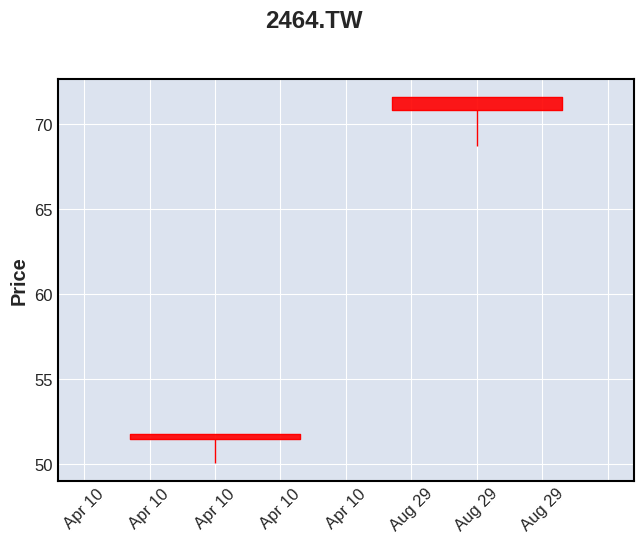

In [21]:
mpf.plot(hammer_df, type='candle', style=my_style, title=f'{stock_id}')

In [22]:
# 計算 K 線長度
df['body_length'] = abs(df['Close'] - df['Open'])

# 定義Doji型態的條件
# 一般來說，body 長度 如果 小於等於 (最高價-最低價) * 0.1
doji_condition = (
    df['body_length'] <= (df['High'] - df['Low']) * 0.1  # 中間區域非常小
)

# 提取Doji形态
doji_df = df[doji_condition]
doji_df.set_index('Date', inplace=True)

doji_df

Price,Close,High,Low,Open,Volume,8_SMA,13_SMA,20_SMA,Change,Gain,...,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD,body_length,lower_shadow,upper_shadow
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-07,58.147591,58.147591,58.147591,58.147591,302361,NaN,NaN,NaN,-6.460838,0.000000,...,NaN,NaN,NaN,NaN,64.637158,66.161554,-1.524396,0.000000,0.000000,0.000000
2025-04-08,52.382530,52.382530,52.382530,52.382530,878343,NaN,NaN,NaN,-5.765060,0.000000,...,NaN,NaN,NaN,NaN,61.913908,64.193122,-2.279214,0.000000,0.000000,0.000000
2025-04-09,47.164158,48.506024,47.164158,47.164158,2191898,60.762989,NaN,NaN,-5.218372,0.000000,...,NaN,NaN,NaN,NaN,58.636185,61.760413,-3.124227,0.000000,0.000000,1.341866
2025-04-23,55.165661,55.861445,54.370481,55.066265,1524801,54.917167,53.992005,NaN,2.484940,2.484940,...,0.962026,1.608110,0.598234,37.430939,54.752739,56.013709,-1.260969,0.099396,0.695784,0.695784
2025-04-30,61.129517,66.397592,60.533133,61.030121,12060483,56.756022,56.350786,56.196911,0.496986,0.496986,...,1.072074,0.404690,2.649123,72.596153,58.014472,57.652132,0.362341,0.099396,0.496988,5.268075
2025-05-08,59.340363,60.036146,59.042171,59.439759,883112,59.725525,57.872334,56.785842,0.596390,0.596390,...,0.745483,0.482789,1.544117,60.693633,59.019582,58.645291,0.374291,0.099396,0.298192,0.596388
2025-06-11,61.328312,62.024096,60.632528,61.328312,1980263,59.564004,59.990267,61.000299,0.099400,0.099400,...,0.532487,0.575086,0.925926,48.076922,60.236897,60.237109,-0.000212,0.000000,0.695784,0.695784
2025-06-26,60.632530,64.707830,60.433734,60.731926,10104847,59.029743,59.783826,59.499396,0.795181,0.795181,...,0.511187,0.418890,1.220339,54.961830,59.403726,59.501514,-0.097789,0.099396,0.198796,3.975904
2025-07-09,54.299999,54.799999,54.200001,54.299999,651608,56.555571,57.557831,58.320872,0.000000,0.000000,...,0.294794,0.590921,0.498871,33.283137,56.190246,57.021837,-0.831591,0.000000,0.099998,0.500000


In [23]:
doji_df.index

DatetimeIndex(['2025-04-07', '2025-04-08', '2025-04-09', '2025-04-23',
               '2025-04-30', '2025-05-08', '2025-06-11', '2025-06-26',
               '2025-07-09', '2025-07-15', '2025-07-31', '2025-08-13',
               '2025-08-14', '2025-08-22', '2025-09-09'],
              dtype='datetime64[ns]', name='Date', freq=None)

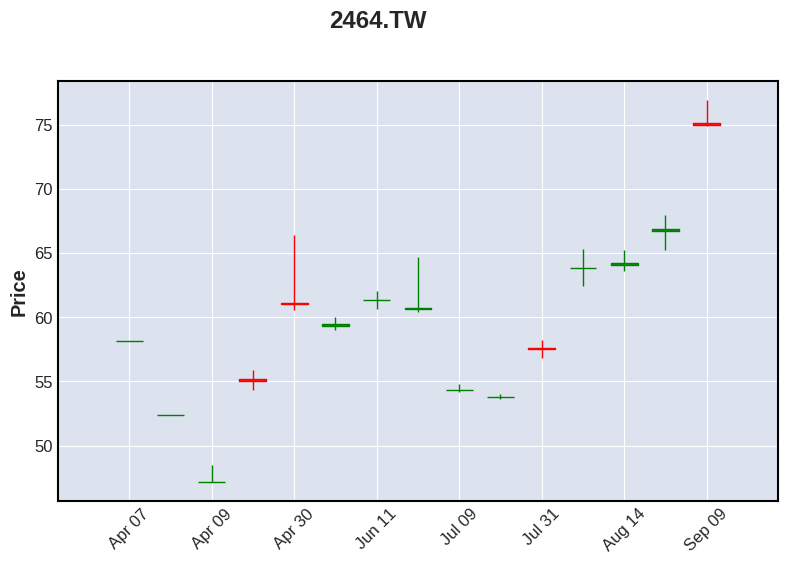

In [24]:
mpf.plot(doji_df, type='candle', style=my_style, title=f'{stock_id}', figsize=(10, 6))

In [25]:
import numpy as np  # 引入 numpy，用於數據處理和數值運算
from sklearn.model_selection import train_test_split  # 引入 train_test_split，用於將數據集拆分為訓練集和測試集
from sklearn.metrics import mean_squared_error  # 引入 mean_squared_error 用於評估模型性能

In [26]:
# 標籤: 預測未來1天的價格，舉例說明:用技術指標預測隔天的收盤價
n = 1
df['Future_Price'] = df['Close'].shift(-n)

# 去除缺失值
df.dropna(inplace=True)

# 使用特徵
X = df[['20_SMA', 'RSI', 'MACD']]

# 標籤（未來價格）
y = df['Future_Price']

X.shape, y.shape

((103, 3), (103,))

In [27]:
# 將數據集 X 和標籤 y 拆分為訓練集和測試集
# test_size=0.2 表示測試集佔全部數據的 20% --> 80% 的資料作為訓練，20% 的資料作為測試
# shuffle=False 表示在拆分數據時不打亂原始數據的順序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 查看拆分後訓練集和測試集的形狀
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82, 3), (21, 3), (82,), (21,))

In [28]:
# 引入線性回歸模型
from sklearn.linear_model import LinearRegression

# 建立並訓練線性回歸模型
model = LinearRegression()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"線性回歸模型RMSE: {rmse:.2f}")

# 使用模型進行未來價格走勢預測
future_pred = model.predict(X[-1:])  # 使用最新的數據進行預測
print(f"線性回歸模型預測未來{n}天的價格: {future_pred[0]:.2f}")

線性回歸模型RMSE: 3.89
線性回歸模型預測未來1天的價格: 67.57


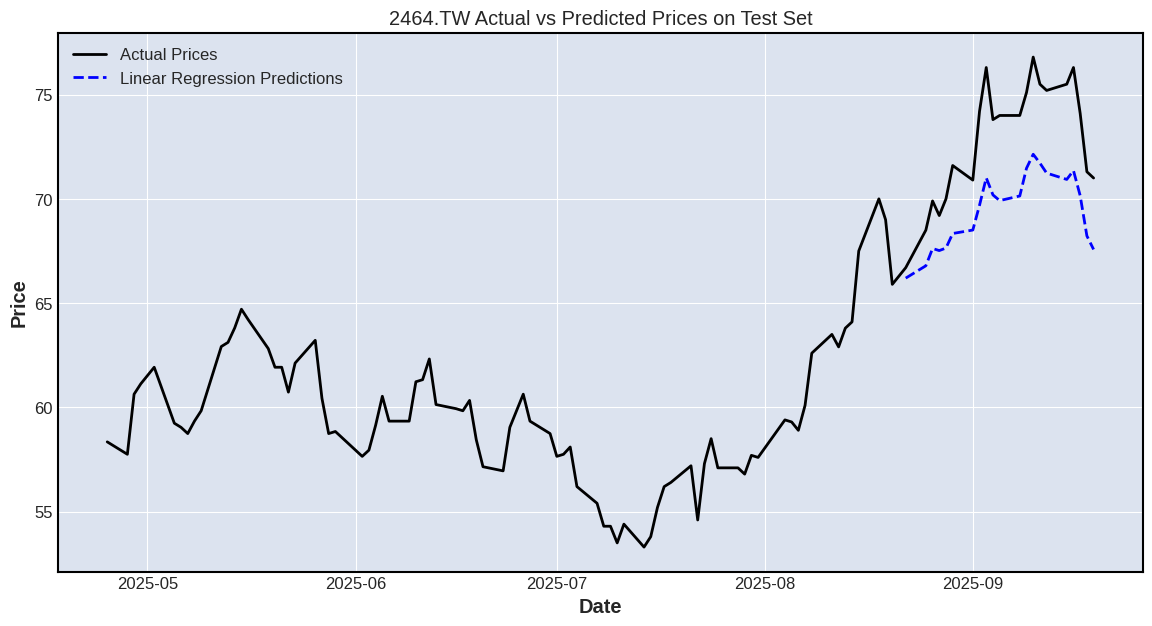

In [30]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Linear Regression Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2464.TW Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
from sklearn.tree import DecisionTreeRegressor

# 建立並訓練決策數模型
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"決策樹模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"決策樹模型預測未來{n}天的價格: {future_pred[0]:.2f}")

決策樹模型RMSE: 8.47
決策樹模型預測未來1天的價格: 58.74


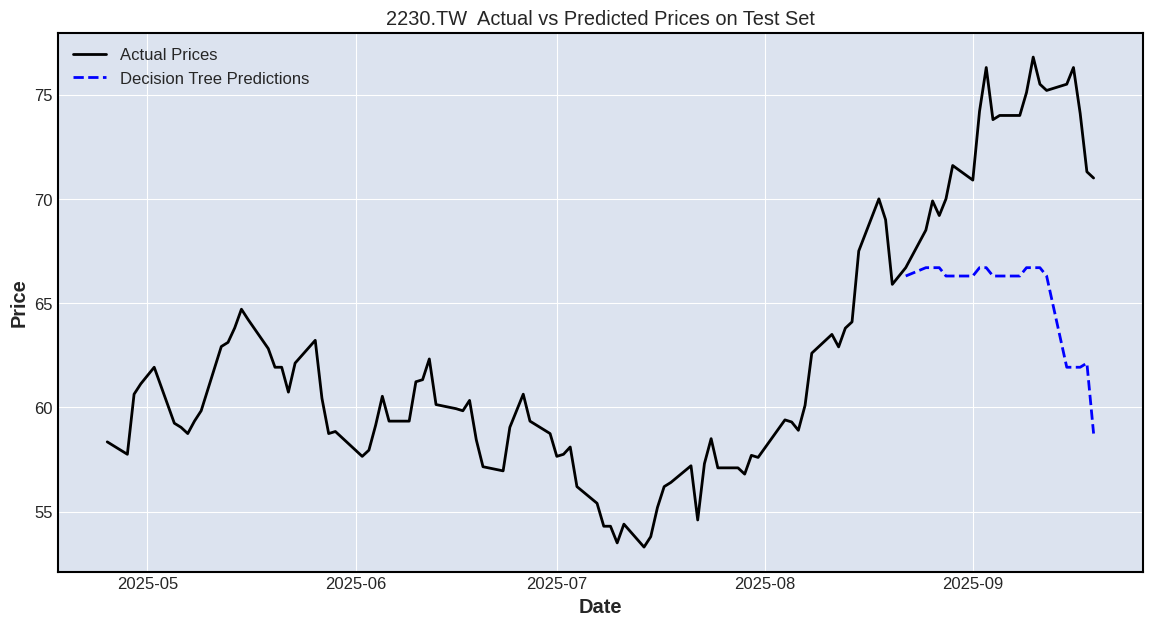

In [32]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Decision Tree Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2464.TW  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# 引入隨機森林模型
from sklearn.ensemble import RandomForestRegressor

# 建立並訓練決策數模型
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"隨機森林模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"隨機森林模型預測未來{n}天的價格: {future_pred[0]:.2f}")

隨機森林模型RMSE: 8.39
隨機森林模型預測未來1天的價格: 59.33


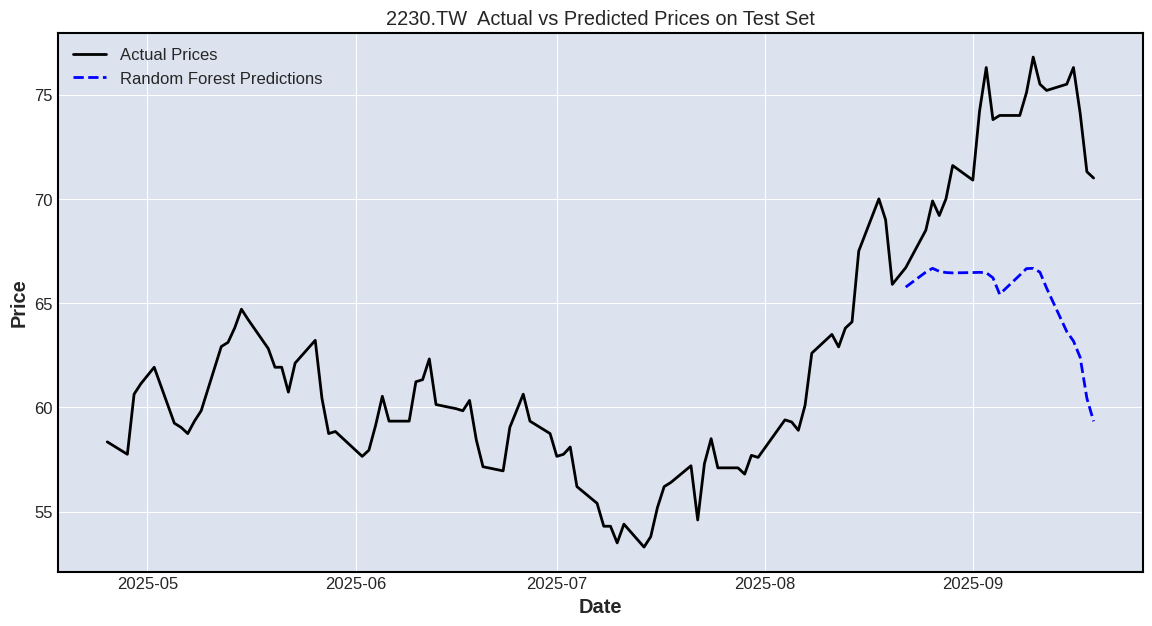

In [34]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Random Forest Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()